# **Predicting the Sales (Domestic Ultimate Total USD) of various companies using Machine Learning Models.**

## **1. Setting the environment for the project.**

### Intall necessary packages used in the following project. 

In [12]:
#%pip install pandas 
#%pip install matplotlib
#%pip install numpy
#%pip install seaborn
#%pip install statsmodels
#%pip install scikit-learn

### Import necessary modules. 

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor



### Create a folder named 'data' in your current working directory and have the .csv file inside that. 
### Set a relative path for importing the data file. 

In [2]:
#filepath = "../data/catA_train.csv" 
filepath = "/Users/yunjihyun/Desktop/data/catA_train.csv"

## **2. Importing the data set**

In [8]:
data = pd.read_csv(filepath)

## **3. Data Preprocessing**

In [9]:
def data_processing(data): 

    # Drop variables that are not necessary 
    columns_to_drop = ["LATITUDE", "LONGITUDE", '8-Digit SIC Code', 'Sales (Global Ultimate Total USD)', "AccountID", "Company", "Industry", "8-Digit SIC Description", "Parent Company", "Company Description", "Square Footage", "Company Status (Active/Inactive)", "Import/Export Status", "Fiscal Year End", "Global Ultimate Company", "Domestic Ultimate Company"]
    data = data.drop(columns=columns_to_drop)

    # Drop rows with missing values for the following 3 variables
    data = data.dropna(subset=["Year Found", "Parent Country", "Global Ultimate Country"])

    # Categorize "SIC Code" 
    data['SIC Code'] = pd.to_numeric(data['SIC Code'])

    def categorize_industry(sic_code):
        if 100 <= sic_code <= 999:
            return 'Agriculture, Forestry, And Fishing'
        elif 1000 <= sic_code <= 1499:
            return 'Mining'
        elif 1500 <= sic_code <= 1799:
            return 'Construction'
        elif 2000 <= sic_code <= 3999:
            return 'Manufacturing'
        elif 4000 <= sic_code <= 4999:
            return 'Transportation, Communications, Electric, Gas, And Sanitary Services'
        elif 5000 <= sic_code <= 5199:
            return 'Wholesale Trade'
        elif 5200 <= sic_code <= 5999:
            return 'Retail Trade'
        elif 6000 <= sic_code <= 6799:
            return 'Finance, Insurance, And Real Estate'
        elif 7000 <= sic_code <= 8999:
            return 'Services'
        elif 9000 <= sic_code <= 9999:
            return 'Public Administration'
        else:
            return 'Other'  # Handle cases not covered by the specified ranges

    # Create a new 'Industry' column of categorized "SIC Code"
    data['Industry'] = data['SIC Code'].apply(categorize_industry)

    # Drop the original SIC Code column
    data = data.drop('SIC Code', axis=1)

    # One-Hot Encoding for "Industry" - converting a categorical variable into a numeric variable
    industry_frequency = data["Industry"].value_counts()
    industry_dummies = pd.get_dummies(data["Industry"])
    data = pd.concat([data, industry_dummies], axis='columns')
    data = data.drop(['Industry'], axis='columns')

    # One-Hot Encoding for "Entity Type" - converting a categorical variable into a numeric variable
    entity_frequency = data["Entity Type"].value_counts()
    # 4 categories: "Branch", "Independent", "Parent", "Subsidiary"
    entity_dummies = pd.get_dummies(data["Entity Type"])
    data = pd.concat([data, entity_dummies], axis='columns')
    data = data.drop(['Entity Type'], axis='columns')

    # One-Hot Encoding for "Ownership Type" - converting a categorical variable into a numeric variable
    ownership_frequency = data["Ownership Type"].value_counts()
    # 6 categories: "Private", "Public", "Partnership", "Public Sector", "Non-Corporates", "Nonprofit"
    ownership_dummies = pd.get_dummies(data["Ownership Type"])
    data = pd.concat([data, ownership_dummies], axis='columns')
    data = data.drop(['Ownership Type'], axis='columns')

    # Label Encoding for Parent Country - converting a categorical variable into a numeric variable
    parent_frequency = data['Parent Country'].value_counts()
    parent_frequency # 69 countries
    threshold = 3 # Set a threshold for low-frequency countries
    # Identify Countries with frequency below the threshold
    low_frequency_parent_country = parent_frequency[parent_frequency < threshold].index
    # Replace these low-frequency countries with a common label "Others"
    data['Parent Country'] = data['Parent Country'].replace(low_frequency_parent_country, 'Others')

    parent_frequency1 = data['Parent Country'].value_counts()
    data['Parent Country'] = data['Parent Country'].astype(str)
    label_encoder = LabelEncoder()
    data['Parent Country'] = label_encoder.fit_transform(data['Parent Country'])

    # Label Encoding for Global Ultimate Country - converting a categorical variable into a numeric variable
    global_frequency = data['Global Ultimate Country'].value_counts()
    global_frequency # 74 countries
    threshold = 5 # Set a threshold for low-frequency countries
    # Identify Countries with frequency below the threshold
    low_frequency_global_country = global_frequency[global_frequency < threshold].index
    # Replace these low-frequency countries with a common label "Others"
    data['Global Ultimate Country'] = data['Global Ultimate Country'].replace(low_frequency_global_country, 'Others')

    global_frequency1 = data['Global Ultimate Country'].value_counts()
    data['Global Ultimate Country'] = data['Global Ultimate Country'].astype(str)
    label_encoder = LabelEncoder()
    data['Global Ultimate Country'] = label_encoder.fit_transform(data['Global Ultimate Country'])

    return data

# preprocessed data set 
data = data_processing(data)

## **4. Imputing Missing Values using Regression Imputation**

In [10]:
# Predicting missing values using Bayesian Linear Regression 
def imputing(data):

    missing_col = ['Employees (Single Site)', 'Employees (Domestic Ultimate Total)', 'Employees (Global Ultimate Total)']
    column_list = data.columns.tolist()
    predic_col = [col for col in column_list if col not in missing_col]

    imputer = IterativeImputer(estimator=BayesianRidge())
    imputed_data = imputer.fit_transform(data[predic_col + missing_col])
    data[missing_col] = imputed_data[:, -len(missing_col):]

    return data

# data set with no missing values 
data = imputing(data)

## **5. Data Visualization**

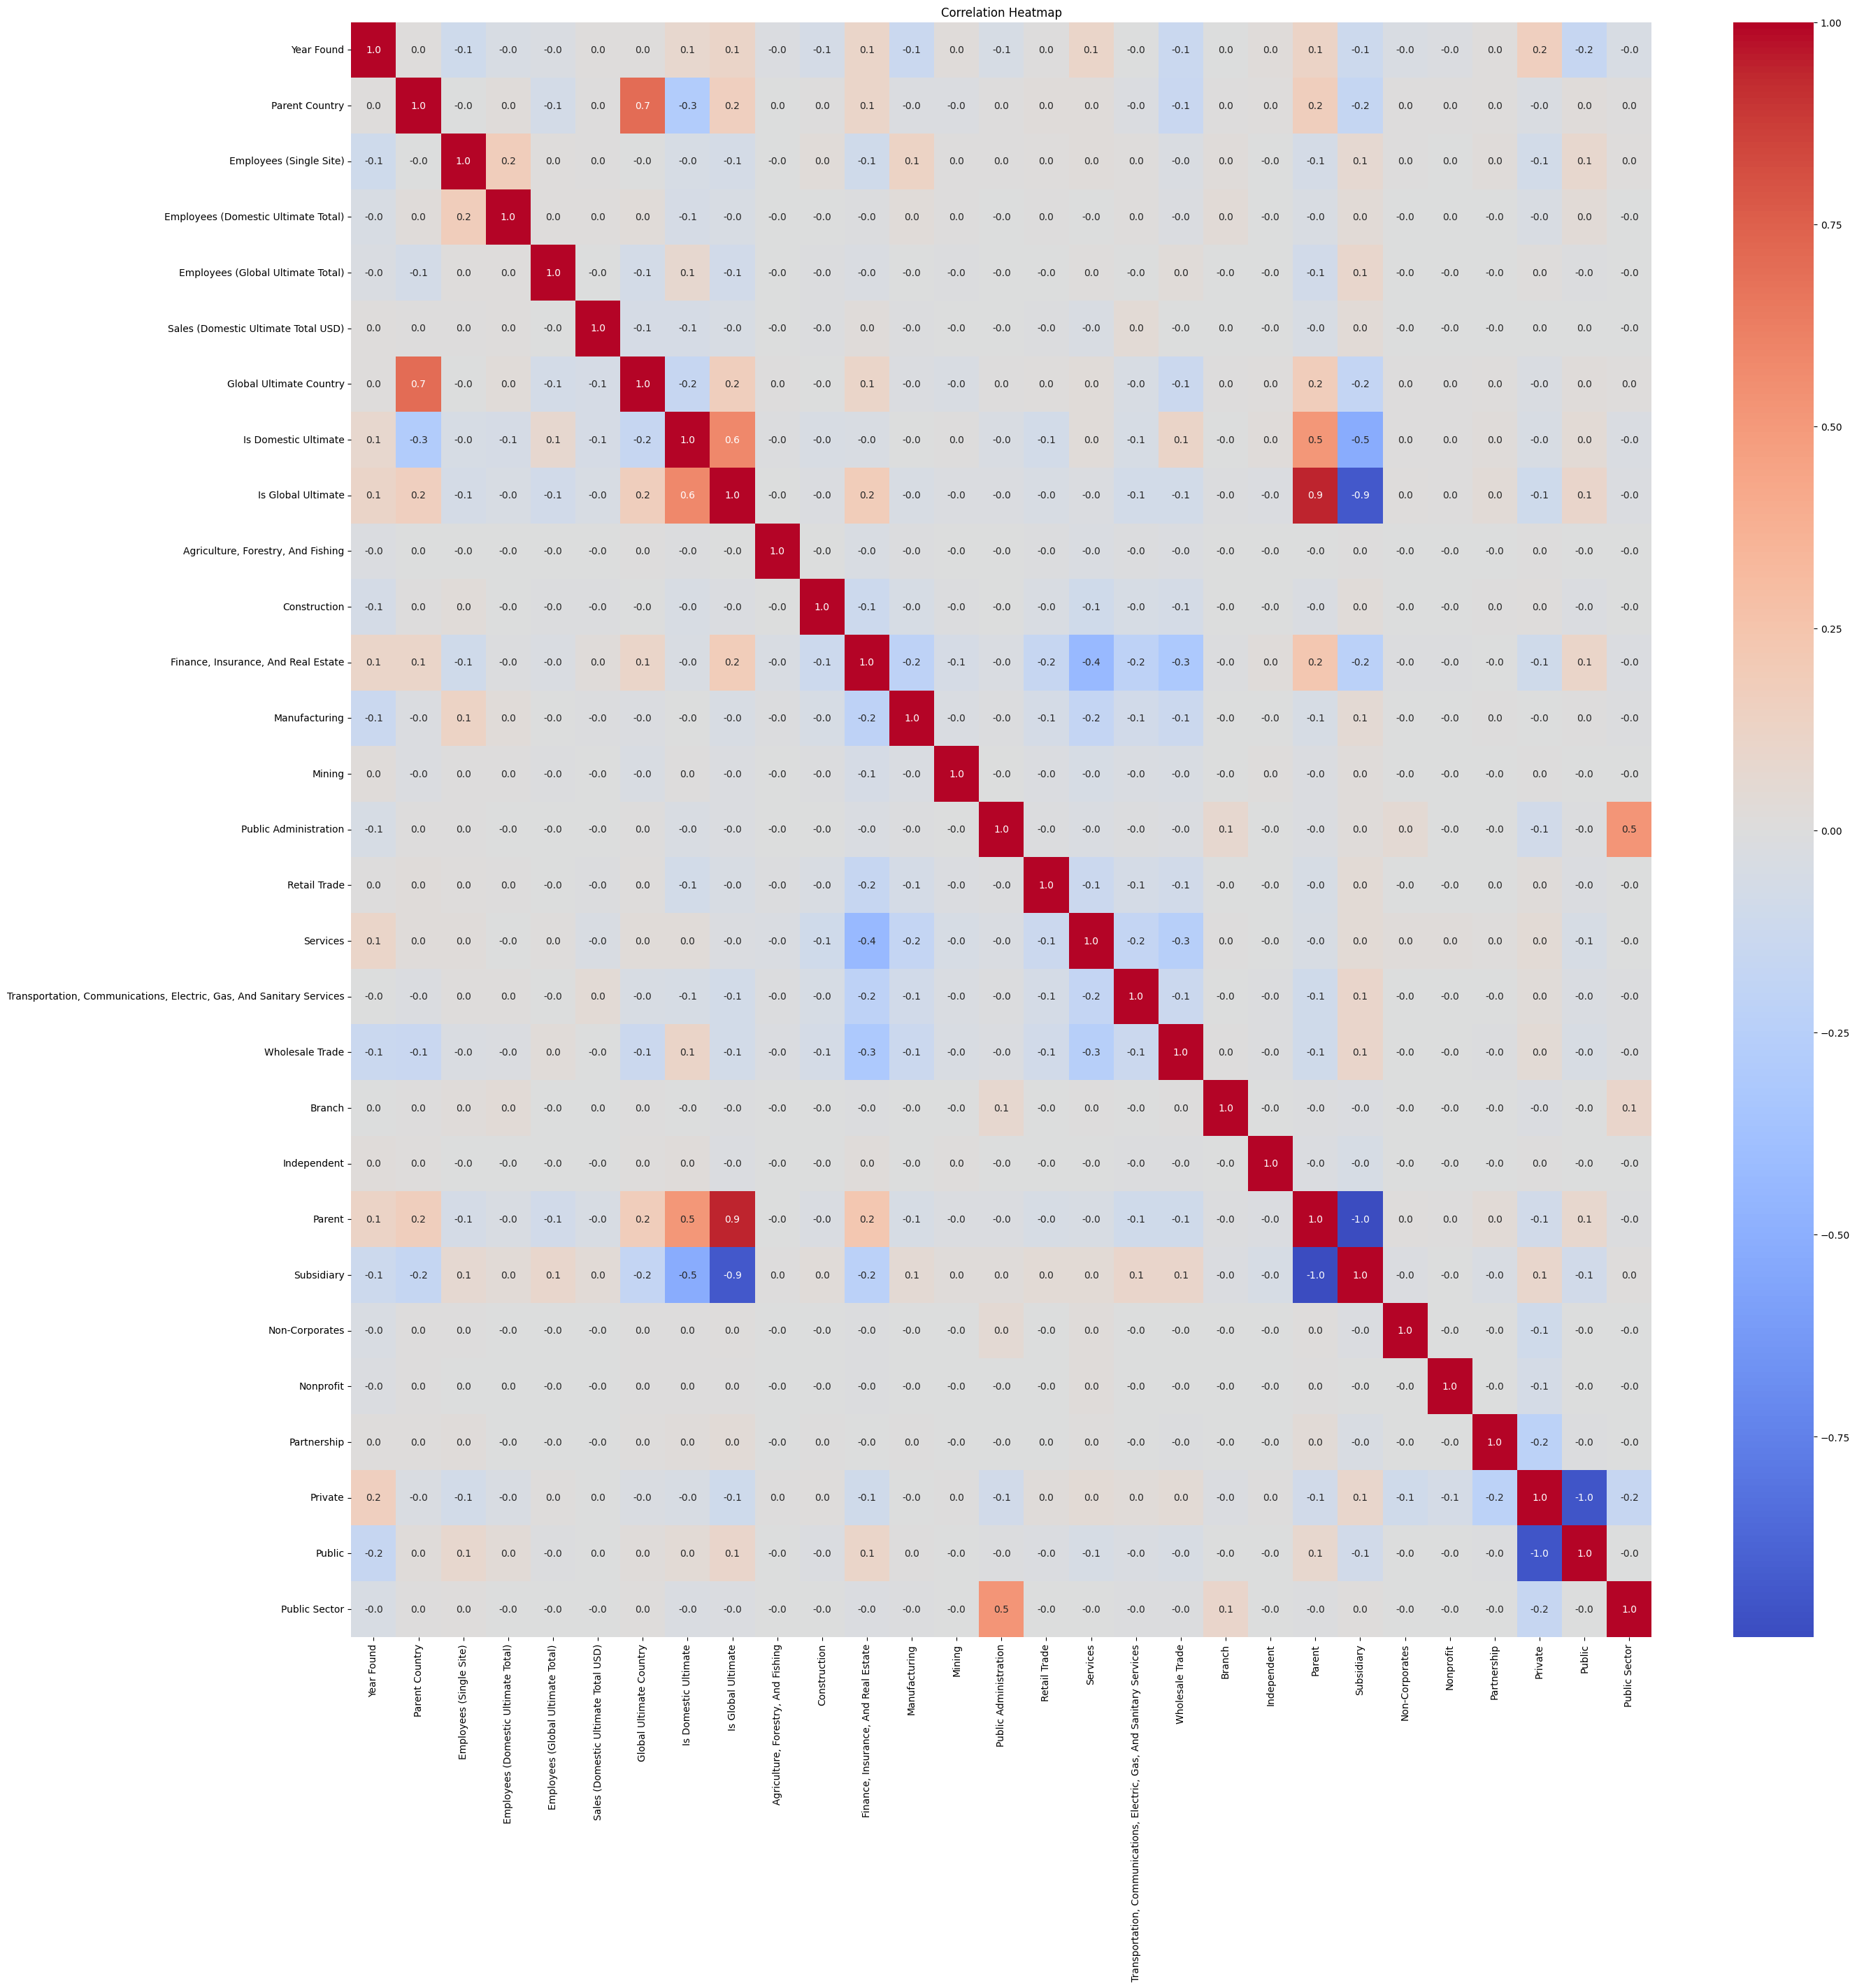

In [11]:
# Data Visualization using correlation heatmap
plt.figure(figsize=(30, 30))
correlation_matrix = data.corr()
heatmap = sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".1f")
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.title("Correlation Heatmap")
plt.show() 

##### Variables "Parent" and "Subsidary" demonstrates significantly high correlation (approx. 0.9) with the variable "Is Globale Ultimate". 
##### Therefore, "Is Global Ultimate" variable will be taken into account, while "Parent" and "Subsidary" variables are dropped.

## **6. Feature Scaling using Normalization**

In [12]:
def feature_scaling(data):
    scaler = MinMaxScaler()    
    return data

# normalized data 
data = feature_scaling(data)

## **7. Selecting Features**

In [13]:
target_feature = 'Sales (Domestic Ultimate Total USD)'

correlation_with_target = correlation_matrix[target_feature]
sorted_correlations = correlation_with_target.abs().sort_values(ascending=False)
sorted_correlations = sorted_correlations.drop(target_feature)

print("Features in Descending Order of Correlation:\n", sorted_correlations)
print("Top 10 Features:\n", sorted_correlations[:10])

Features in Descending Order of Correlation:
 Global Ultimate Country                                                 0.060760
Is Domestic Ultimate                                                    0.056515
Transportation, Communications, Electric, Gas, And Sanitary Services    0.047409
Is Global Ultimate                                                      0.040201
Subsidiary                                                              0.038416
Parent                                                                  0.038329
Services                                                                0.032597
Finance, Insurance, And Real Estate                                     0.022524
Employees (Domestic Ultimate Total)                                     0.016033
Year Found                                                              0.015215
Retail Trade                                                            0.013135
Manufacturing                                                  

##### Select features with over 0.01 correlation with the target feature, which is "Sales (Domestic Ultimate Total USD)". 

In [14]:
def feature_selection(data):
    columns_to_keep = ['Global Ultimate Country', 'Is Domestic Ultimate', 'Transportation, Communications, Electric, Gas, And Sanitary Services', 'Is Global Ultimate', 'Services', 'Finance, Insurance, And Real Estate', 'Employees (Domestic Ultimate Total)', 'Year Found', 'Retail Trade', 'Manufacturing']
    data = data[columns_to_keep]
    return data

### **Splitting the data set into Training Set and Testing Set**

In [15]:
X = feature_selection(data)

y = data[['Sales (Domestic Ultimate Total USD)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **8. Training Machine Learning Models**

### **Random Forest Regressor**

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 2.8464460865384255e+19
R-squared: 0.8229674372726017


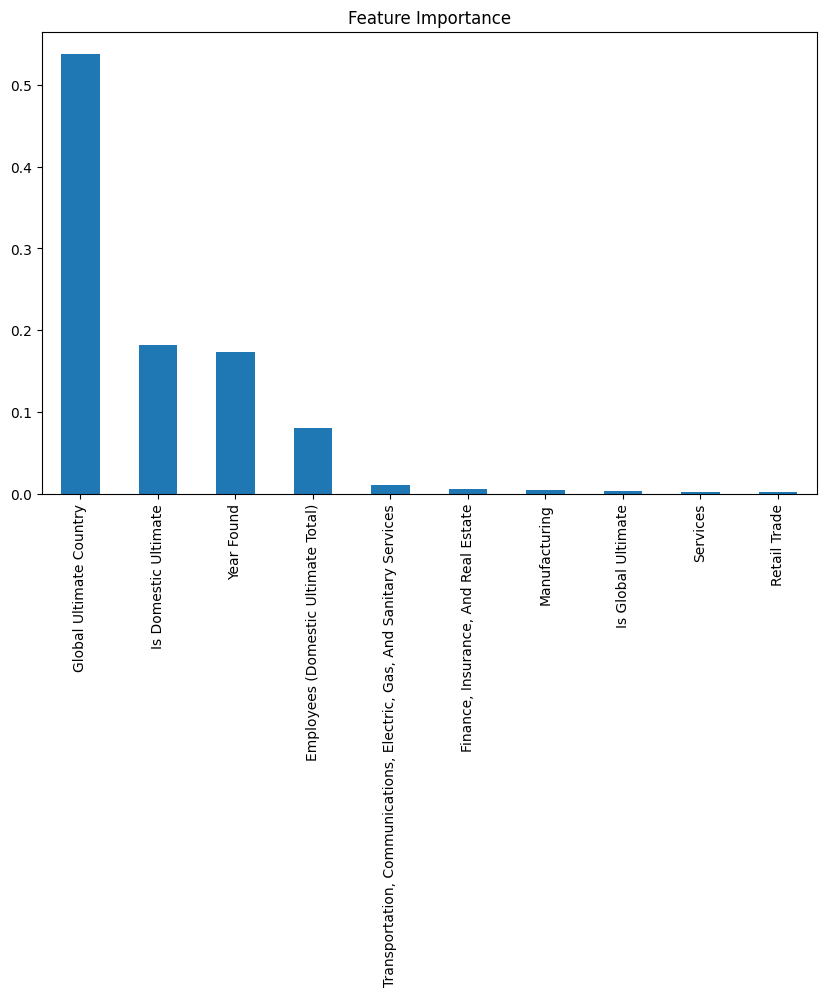

In [16]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Check feature importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

### **Cross Validation of Random Forest Regressor**

In [17]:
# Cross Validation with k_fold (k=10)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Custom scoring functions
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Store metrics for each fold
r2_scores = []
adj_r2_scores = []
aic_bic_scores = []
mse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit RandomForestRegressor
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    # Calculate R² and adjusted R²
    r2 = r2_score(y_test, y_pred)
    n = X_test.shape[0]
    p = X_test.shape[1]
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

    # Calculate AIC/BIC using statsmodels
    X_train_sm = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_sm).fit()
    aic_bic = model.aic, model.bic

    # Calculate MSE and MAE
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Store metrics for each fold
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    aic_bic_scores.append(aic_bic)
    mse_scores.append(mse)
    mae_scores.append(mae)

# Display the results
print(f"Average R²: {np.mean(r2_scores)}")
print(f"Average Adj R²: {np.mean(adj_r2_scores)}")
print(f"Average AIC/BIC: {np.mean(aic_bic_scores, axis=0)}")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklea

Average R²: 0.6795336749207752
Average Adj R²: 0.6783941720277199
Average AIC/BIC: [1243805.61467118 1243895.18680975]
Average MSE: 2.5517958476898365e+19
Average MAE: 689706580.1512997


### **Gradient Boosting Regressor**

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 1.9609856963663528e+19
R-squared: 0.7890017547141321


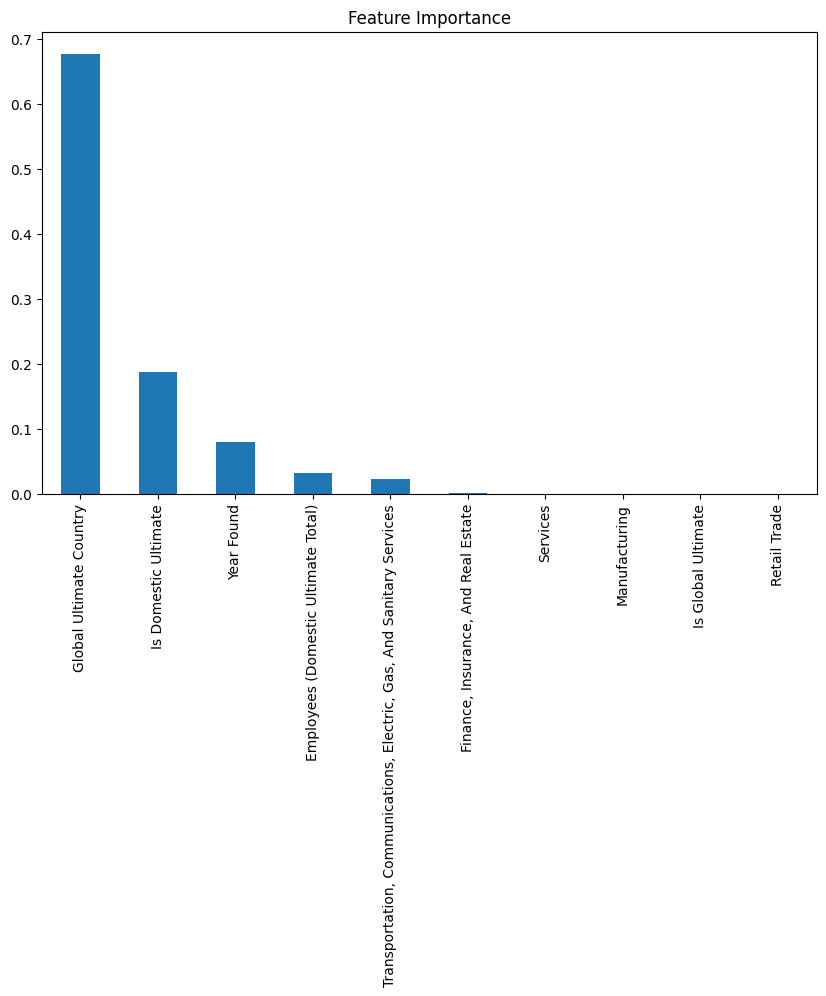

In [18]:
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_model.fit(X_train, y_train)
y_pred = gbm_model.predict(X_test)

gb_mse = mean_squared_error(y_test, y_pred)
gb_r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {gb_mse}')
print(f'R-squared: {gb_r2}')

# Check feature importance
feature_importances = pd.Series(gbm_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

### **Cross Validation of Gradient Boosting Regressor**

In [19]:
# Cross-validation with k-fold (k=10)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Custom scoring functions
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Store metrics for each fold
r2_scores = []
adj_r2_scores = []
aic_bic_scores = []
mse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit GradientBoostingRegressor
    gbm_model.fit(X_train, y_train)
    y_pred = gbm_model.predict(X_test)

    # Calculate R² and adjusted R²
    r2 = r2_score(y_test, y_pred)
    n = X_test.shape[0]
    p = X_test.shape[1]
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

    # Calculate AIC/BIC using statsmodels
    X_train_sm = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_sm).fit()
    aic_bic = model.aic, model.bic

    # Calculate MSE and MAE
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Store metrics for each fold
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)
    aic_bic_scores.append(aic_bic)
    mse_scores.append(mse)
    mae_scores.append(mae)

# Display results
print(f"Average R²: {np.mean(r2_scores)}")
print(f"Average Adj R²: {np.mean(adj_r2_scores)}")
print(f"Average AIC/BIC: {np.mean(aic_bic_scores, axis=0)}")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:42

Average R²: 0.6694613745860925
Average Adj R²: 0.6682860452243751
Average AIC/BIC: [1243805.61467118 1243895.18680975]
Average MSE: 2.589348578452163e+19
Average MAE: 793395181.8220131


## **9. Conclusion**

##### In conclusion, the random forest regressor model demonstrates a better performance compared to the gradient boosting model. 
##### Both the average R-squared and adjusted R-squared value is higher in the random forest regressor model compared to the gradient bossting model. 
##### Both the average MSE and MAE values are closer to 0 in the random forest regressor model compared to the gradient bossting model.
##### Therefore, the random forest regressor model will be chosen to make predictions. 

## **10. Making Predictions using the Random Forest Regressor Model**

In [20]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    hidden_data = data_processing(hidden_data)
    hidden_data = imputing(hidden_data)
    hidden_data = feature_scaling(hidden_data)
    hidden_data = feature_selection(hidden_data)
    predictions = rf_model.predict(hidden_data)
    return predictions

#### Check the testing_hidden_data function

In [21]:
# Output the predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))


[3.40304960e+07 5.65127003e+09 1.08693071e+07 ... 1.32964066e+08
 6.20602781e+06 4.60971140e+06]


### **Evaluate the performance of the model.**

In [23]:
real_data = pd.read_csv(filepath)
real_data = data_processing(real_data)
real_data = imputing(real_data)
real_data = feature_scaling(real_data)
actual_sales = real_data['Sales (Domestic Ultimate Total USD)']
predicted_sales = testing_hidden_data(test_df)

mae = mean_absolute_error(actual_sales, predicted_sales)
mse = mean_squared_error(actual_sales, predicted_sales)
r2 = r2_score(actual_sales, predicted_sales)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Mean Absolute Error: 469158206.5487433
Mean Squared Error: 1.3105344664552466e+19
R-squared: 0.8779890209452458


##### The Mean Squared Error (MSE), a measure of the average squared differences between predicted and actual values, is remarkably high at approximately 1.31e+19, suggesting that the model's predictions are closer to the actual values. 
##### The R-squared value of approximately 0.88 is quite promising, indicating a good fit of the predictions made by the model in relation to the actual data. 